In [8]:
# 🎯 Top Talent Negotiation - Comprehensive Analysis Dashboard
"""
Complete analysis of Top Talent negotiations (Recruiter vs Candidate)

Analysis Sections:
1. 📋 All Negotiation Records Overview
2. 📈 Total Pie & Human Share Distributions
3. 🧠 AI vs Human Performance Tests
4. 👥 Student Demographics & Characteristics Analysis
5. 🎭 Treatment Variations (Role & First Mover)
"""

'\nComplete analysis of Top Talent negotiations (Recruiter vs Candidate)\n\nAnalysis Sections:\n1. 📋 All Negotiation Records Overview\n2. 📈 Total Pie & Human Share Distributions\n3. 🧠 AI vs Human Performance Tests\n4. 👥 Student Demographics & Characteristics Analysis\n5. 🎭 Treatment Variations (Role & First Mover)\n'

In [9]:
# ==================== SETUP ====================
import importlib.util
import json
import sqlite3
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

from TTverifier_and_scorer import verify_and_score_top_talent

warnings.filterwarnings("ignore")

# ==================== CONFIGURATION ====================
DB_PATH = "negotiations.db"
SCENARIO_FILTER = "Top_talent"
CUTOFF_TIME = "2025-12-10 14:36"
EXCLUDED_MAJORS = {"sds"}

OUTPUT_TOP_TALENT_CSV =  "top_talent_sessions.csv"
OUTPUT_MAIN_STREET_CSV = "main_street_sessions.csv"

# ==================== OPTIONAL STATS ====================
scipy_stats = None
if importlib.util.find_spec("scipy") is not None:
    from scipy import stats as scipy_stats


# ==================== HELPERS ====================

def configure_display():
    pd.set_option("display.max_rows", None)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", None)
    pd.set_option("display.max_colwidth", 50)


def safe_json_load(json_str):
    if not json_str or json_str == "null":
        return None
    try:
        return json.loads(json_str)
    except json.JSONDecodeError:
        return None


def calculate_duration(start, end):
    try:
        return (pd.to_datetime(end) - pd.to_datetime(start)).total_seconds() / 60
    except (TypeError, ValueError):
        return None


def get_config_label(use_memory, use_plan):
    if use_memory and use_plan:
        return "M+P"
    if use_memory:
        return "M"
    if use_plan:
        return "P"
    return "Base"


def print_header(title, char="=", width=100):
    print("\n" + char * width)
    print(f"{title.center(width)}")
    print(char * width + "\n")


def print_subheader(title, char="-", width=80):
    print("\n" + char * width)
    print(title)
    print(char * width)


def count_rounds(transcript_json):
    transcript = safe_json_load(transcript_json)
    return len(transcript) // 2 if transcript else 0


def load_sessions(conn):
    query_all = """
    SELECT
        session_id,
        scenario_name,
        student_role,
        ai_role,
        ai_model,
        student_goes_first,
        use_memory,
        use_plan,
        total_rounds,
        deal_reached,
        deal_failed,
        status,
        created_at,
        updated_at,
        major,
        gender,
        negotiation_experience,
        transcript,
        student_deal_json,
        ai_deal_json
    FROM negotiation_sessions
    WHERE created_at >= ?
    ORDER BY created_at DESC
    """
    return pd.read_sql_query(query_all, conn, params=[CUTOFF_TIME])


def apply_filters(df, scenario_name=None, excluded_majors=None):
    df = df.copy()

    if scenario_name:
        df = df[df["scenario_name"].str.lower() == scenario_name.lower()].copy()

    if excluded_majors:
        df = df[
            ~df["major"].str.lower().isin(excluded_majors) | df["major"].isna()
        ].copy()

    return df


def add_derived_columns(df):
    df = df.copy()
    df["Config"] = df.apply(lambda r: get_config_label(r["use_memory"], r["use_plan"]), axis=1)
    df["Duration (min)"] = df.apply(
        lambda r: calculate_duration(r["created_at"], r["updated_at"]), axis=1
    )
    df["Outcome"] = df.apply(
        lambda r: "✅ Deal"
        if r["deal_reached"]
        else "❌ Failed"
        if r["deal_failed"]
        else "⏸️ Incomplete",
        axis=1,
    )
    df["Role"] = df["student_role"].map(
        {"side1": "Recruiter", "side2": "Candidate"}
    )
    df["rounds"] = df["transcript"].apply(count_rounds)
    return df


def score_deal(row):
    if not row.get("deal_reached"):
        return {
            "recruiter_points": None,
            "candidate_points": None,
            "true_total_points": None,
            "verified_agreement": None,
        }

    student_deal = safe_json_load(row.get("student_deal_json")) or {}
    ai_deal = safe_json_load(row.get("ai_deal_json")) or {}

    if row.get("student_role") == "side1":
        side1_final = student_deal
        side2_final = ai_deal
    else:
        side1_final = ai_deal
        side2_final = student_deal

    try:
        result = verify_and_score_top_talent(
            side1_final=side1_final,
            side2_final=side2_final,
            deal_reached_token=row.get("deal_reached"),
        )
    except ValueError as exc:
        print(f"⚠️ Scoring failed for session {row.get('session_id')}: {exc}")
        return {
            "recruiter_points": None,
            "candidate_points": None,
            "true_total_points": None,
            "verified_agreement": None,
        }

    return {
        "recruiter_points": result.get("recruiter_points"),
        "candidate_points": result.get("candidate_points"),
        "true_total_points": result.get("true_total_points"),
        "verified_agreement": result.get("verified_agreement"),
    }


def add_scoring_columns(df):
    scored = df.apply(score_deal, axis=1, result_type="expand")
    df = pd.concat([df, scored], axis=1)

    df["student_points"] = np.where(
        df["student_role"] == "side1", df["recruiter_points"], df["candidate_points"]
    )
    df["ai_points"] = np.where(
        df["student_role"] == "side1", df["candidate_points"], df["recruiter_points"]
    )

    df["total_pie"] = df["true_total_points"]
    df["percent_pie_human"] = np.where(
        df["total_pie"] > 0, df["student_points"] / df["total_pie"], np.nan
    )
    df["percent_pie_ai"] = np.where(
        df["total_pie"] > 0, df["ai_points"] / df["total_pie"], np.nan
    )
    return df


def show_overview(df):
    print_header("📋 ALL TOP TALENT NEGOTIATIONS")
    print(f"Total Sessions: {len(df)}")
    print(f"Successful Deals: {df['deal_reached'].sum()}")
    print(f"Failed Negotiations: {df['deal_failed'].sum()}")
    print(f"Incomplete: {(~df['deal_reached'] & ~df['deal_failed']).sum()}")

    print("\n📊 Configuration Breakdown:")
    print(df["Config"].value_counts().to_string())

    print("\n🎭 Role Distribution:")
    print(df["Role"].value_counts().to_string())


def show_overview_table(df):
    display_df = df[[
        "session_id",
        "Role",
        "Config",
        "Outcome",
        "major",
        "gender",
        "negotiation_experience",
        "Duration (min)",
        "created_at",
        "total_pie",
        "percent_pie_human",
        "rounds",
    ]].copy()

    display_df["session_id"] = display_df["session_id"].str[:8]
    display_df["created_at"] = pd.to_datetime(display_df["created_at"]).dt.strftime("%Y-%m-%d %H:%M")
    display_df["Duration (min)"] = display_df["Duration (min)"].round(1)
    display_df["total_pie"] = display_df["total_pie"].apply(
        lambda x: f"{x:,.0f}" if pd.notna(x) else "N/A"
    )
    display_df["percent_pie_human"] = display_df["percent_pie_human"].apply(
        lambda x: f"{x:.1%}" if pd.notna(x) else "N/A"
    )
    display_df["rounds"] = display_df["rounds"].fillna(0).astype(int)

    display_df.columns = [
        "Session",
        "Role",
        "Config",
        "Outcome",
        "Major",
        "Gender",
        "Exp",
        "Duration",
        "Created",
        "Total Pie",
        "Human Share",
        "Rounds",
    ]

    print("\n" + "=" * 150)
    display(display_df)


def analyze_pie_distributions(df_deals):
    print_header("📈 TOTAL PIE & HUMAN SHARE DISTRIBUTIONS")

    if len(df_deals) == 0:
        print("❌ No successful deals found")
        return

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].hist(df_deals["total_pie"].dropna(), bins=25, edgecolor="black", alpha=0.7)
    axes[0].set_title("Distribution of Total Pie Size")
    axes[0].set_xlabel("Total Points")
    axes[0].set_ylabel("Deals")

    axes[1].hist(df_deals["percent_pie_human"].dropna(), bins=20, edgecolor="black", alpha=0.7)
    axes[1].axvline(0.5, color="red", linestyle="--", linewidth=2, label="50-50 split")
    axes[1].set_title("Distribution of Human Share")
    axes[1].set_xlabel("Human % of Total Pie")
    axes[1].set_ylabel("Deals")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    summary = df_deals[["total_pie", "percent_pie_human"]].describe().T
    display(summary.round(2))


def analyze_ai_vs_human(df_deals):
    print_header("🧠 AI vs HUMAN PERFORMANCE TESTS")

    df_valid = df_deals.dropna(subset=["student_points", "ai_points", "total_pie"]).copy()
    if len(df_valid) == 0:
        print("❌ No scored deals available for comparison")
        return

    df_valid["ai_minus_human"] = df_valid["ai_points"] - df_valid["student_points"]

    print(f"Deals with scores: {len(df_valid)}")
    print(f"Average Human Points: {df_valid['student_points'].mean():,.1f}")
    print(f"Average AI Points: {df_valid['ai_points'].mean():,.1f}")
    print(f"Average (AI - Human): {df_valid['ai_minus_human'].mean():,.1f}\n")

    if scipy_stats is None:
        print("⚠️ scipy not available - skipping statistical tests.")
        return

    t_stat, p_two_sided = scipy_stats.ttest_1samp(df_valid["ai_minus_human"], 0, nan_policy="omit")
    p_one_sided = p_two_sided / 2 if t_stat > 0 else 1 - (p_two_sided / 2)

    print("Paired t-test on (AI - Human) points")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  two-sided p-value: {p_two_sided:.4f}")
    print(f"  one-sided p-value (AI > Human): {p_one_sided:.4f}")


def analyze_demographics(df_deals):
    print_header("👥 STUDENT DEMOGRAPHICS & PERFORMANCE")

    def plot_distribution(series, title, xlabel, min_count=1):
        counts = series.dropna().value_counts()
    
        if counts.empty:
            print(f"No {title.lower()} data available")
            return
    
        # Optional: collapse very rare categories
        if min_count > 1:
            rare = counts[counts < min_count]
            counts = counts[counts >= min_count]
            if len(rare) > 0:
                counts.loc["Other"] = rare.sum()
    
        counts = counts.sort_values()  # important for horizontal bars
    
        fig_height = max(4, 0.45 * len(counts))
        fig, ax = plt.subplots(figsize=(10, fig_height))
    
        counts.plot(kind="barh", ax=ax)
    
        ax.set_title(title)
        ax.set_xlabel("Count")
        ax.set_ylabel(xlabel)
    
        # Annotate bars (small but helpful)
        for i, v in enumerate(counts.values):
            ax.text(v + 0.05, i, str(v), va="center", fontsize=9)
    
        plt.tight_layout()
        plt.show()


    print_subheader("📚 Academic Major Distribution")
    plot_distribution(df_deals["major"], "Academic Major Distribution", "Major")

    print_subheader("⚧ Gender Distribution")
    plot_distribution(df_deals["gender"], "Gender Distribution", "Gender")

    print_subheader("💼 Negotiation Experience Distribution")
    plot_distribution(
        df_deals["negotiation_experience"],
        "Negotiation Experience Distribution",
        "Experience Level",
    )

    print_subheader("📊 Performance by Demographics")
    group_cols = ["major", "gender", "negotiation_experience"]
    for col in group_cols:
        if df_deals[col].dropna().empty:
            continue

        summary = (
            df_deals.groupby(col)
            .agg(
                n_deals=("session_id", "count"),
                avg_total_pie=("total_pie", "mean"),
                avg_human_share=("percent_pie_human", "mean"),
            )
            .sort_values("avg_total_pie", ascending=False)
        )
        print_subheader(f"Performance by {col}")
        display(summary.round(2))


def analyze_treatments(df_deals):
    print_header("🎭 TREATMENT VARIATIONS")

    if len(df_deals) == 0:
        print("❌ No successful deals found")
        return

    print_subheader("Role Breakdown")
    role_summary = df_deals.groupby("Role").agg(
        n_deals=("session_id", "count"),
        avg_total_pie=("total_pie", "mean"),
        avg_human_share=("percent_pie_human", "mean"),
    )
    display(role_summary.round(2))

    print_subheader("First Mover Breakdown")
    mover_summary = df_deals.groupby("student_goes_first").agg(
        n_deals=("session_id", "count"),
        avg_total_pie=("total_pie", "mean"),
        avg_human_share=("percent_pie_human", "mean"),
    )
    mover_summary.index = mover_summary.index.map({1: "Student First", 0: "AI First"})
    display(mover_summary.round(2))

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    role_summary["avg_total_pie"].plot(kind="bar", ax=axes[0], title="Avg Total Pie by Role")
    axes[0].set_ylabel("Total Points")

    mover_summary["avg_total_pie"].plot(kind="bar", ax=axes[1], title="Avg Total Pie by First Mover")
    axes[1].set_ylabel("Total Points")

    plt.tight_layout()
    plt.show()

In [10]:
# ==================== TOP TALENT — FIGURE SAVING + DIRECTORY MANAGEMENT ====================
# Drop this into your Top Talent notebook/script (after your imports).
# It will:
#   1) Create an organized output directory for this run
#   2) Save EVERY figure produced by the plotting functions below with clean, descriptive filenames
#   3) Still show plots (toggle SHOW_PLOTS)

from pathlib import Path
import re
from datetime import datetime
import matplotlib.pyplot as plt

# ---------- Output configuration ----------
OUTPUT_ROOT = Path("outputs")
RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
SCENARIO_SLUG = "top_talent"

OUTPUT_DIR = OUTPUT_ROOT / SCENARIO_SLUG / RUN_ID
FIG_DIR = OUTPUT_DIR / "figures"
EXPORT_DIR = OUTPUT_DIR / "exports"  # optional: use for CSVs too

SAVE_FIGURES = True
SHOW_PLOTS = True
FIG_FORMATS = ("png",)
FIG_DPI = 200

FIG_DIR.mkdir(parents=True, exist_ok=True)
EXPORT_DIR.mkdir(parents=True, exist_ok=True)
print(f"📁 Top Talent figures will be saved to: {FIG_DIR.resolve()}")
print(f"📁 Top Talent exports (optional) will be saved to: {EXPORT_DIR.resolve()}")

# Optional: make your CSV outputs land in the run folder (safe to override)
# (pandas accepts Path objects)
OUTPUT_TOP_TALENT_CSV = EXPORT_DIR / "top_talent_sessions.csv"
OUTPUT_MAIN_STREET_CSV = EXPORT_DIR / "main_street_sessions.csv"

_FIG_SEQ = 0

def _slugify(text: str) -> str:
    text = str(text).strip().lower()
    text = re.sub(r"[^a-z0-9]+", "_", text)
    return text.strip("_") or "figure"

def _ensure_unique_path(path: Path) -> Path:
    if not path.exists():
        return path
    stem, suffix = path.stem, path.suffix
    for i in range(2, 1000):
        candidate = path.with_name(f"{stem}_{i:02d}{suffix}")
        if not candidate.exists():
            return candidate
    raise RuntimeError(f"Could not find a unique filename for {path}")

def save_figure(fig, name: str, subdir=None, formats=FIG_FORMATS, dpi=FIG_DPI):
    global _FIG_SEQ
    if not SAVE_FIGURES:
        return []

    _FIG_SEQ += 1
    out_dir = FIG_DIR / (Path(subdir) if subdir else Path())
    out_dir.mkdir(parents=True, exist_ok=True)

    slug = _slugify(name)
    prefix = f"{_FIG_SEQ:03d}__"
    saved = []

    for ext in formats:
        out_path = _ensure_unique_path(out_dir / f"{prefix}{slug}.{ext}")
        fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
        saved.append(out_path)

    return saved

def finalize_figure(fig, name: str, subdir=None):
    paths = save_figure(fig, name=name, subdir=subdir)
    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close(fig)
    return paths


# -------------------------------------------------------------------------------------------
# UPDATED PLOTTING FUNCTIONS (replace your existing versions with these)
# NOTE: These assume your existing helpers still exist:
#   print_header, print_subheader
# -------------------------------------------------------------------------------------------

def analyze_pie_distributions(df_deals):
    print_header("📈 TOTAL PIE & HUMAN SHARE DISTRIBUTIONS")

    if len(df_deals) == 0:
        print("❌ No successful deals found")
        return

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].hist(df_deals["total_pie"].dropna(), bins=25, edgecolor="black", alpha=0.7)
    axes[0].set_title("Distribution of Total Pie Size")
    axes[0].set_xlabel("Total Points")
    axes[0].set_ylabel("Deals")

    axes[1].hist(df_deals["percent_pie_human"].dropna(), bins=20, edgecolor="black", alpha=0.7)
    axes[1].axvline(0.5, color="red", linestyle="--", linewidth=2, label="50-50 split")
    axes[1].set_title("Distribution of Human Share")
    axes[1].set_xlabel("Human % of Total Pie")
    axes[1].set_ylabel("Deals")
    axes[1].legend()

    plt.tight_layout()
    finalize_figure(fig, "pie_total_and_human_share_distributions", subdir="pie")

    summary = df_deals[["total_pie", "percent_pie_human"]].describe().T
    display(summary.round(2))


def analyze_demographics(df_deals):
    print_header("👥 STUDENT DEMOGRAPHICS & PERFORMANCE")

    def plot_distribution(series, title, xlabel, fig_name, min_count=1):
        counts = series.dropna().value_counts()

        if counts.empty:
            print(f"No {title.lower()} data available")
            return

        # Optional: collapse very rare categories
        if min_count > 1:
            rare = counts[counts < min_count]
            counts = counts[counts >= min_count]
            if len(rare) > 0:
                counts.loc["Other"] = rare.sum()

        counts = counts.sort_values()  # important for horizontal bars

        fig_height = max(4, 0.45 * len(counts))
        fig, ax = plt.subplots(figsize=(10, fig_height))

        counts.plot(kind="barh", ax=ax)

        ax.set_title(title)
        ax.set_xlabel("Count")
        ax.set_ylabel(xlabel)

        # Annotate bars
        for i, v in enumerate(counts.values):
            ax.text(v + 0.05, i, str(v), va="center", fontsize=9)

        plt.tight_layout()
        finalize_figure(fig, fig_name, subdir="demographics")

    print_subheader("📚 Academic Major Distribution")
    plot_distribution(df_deals["major"], "Academic Major Distribution", "Major", "major_distribution")

    print_subheader("⚧ Gender Distribution")
    plot_distribution(df_deals["gender"], "Gender Distribution", "Gender", "gender_distribution")

    print_subheader("💼 Negotiation Experience Distribution")
    plot_distribution(
        df_deals["negotiation_experience"],
        "Negotiation Experience Distribution",
        "Experience Level",
        "negotiation_experience_distribution",
    )

    print_subheader("📊 Performance by Demographics")
    group_cols = ["major", "gender", "negotiation_experience"]
    for col in group_cols:
        if df_deals[col].dropna().empty:
            continue

        summary = (
            df_deals.groupby(col)
            .agg(
                n_deals=("session_id", "count"),
                avg_total_pie=("total_pie", "mean"),
                avg_human_share=("percent_pie_human", "mean"),
            )
            .sort_values("avg_total_pie", ascending=False)
        )
        print_subheader(f"Performance by {col}")
        display(summary.round(2))


def analyze_treatments(df_deals):
    print_header("🎭 TREATMENT VARIATIONS")

    if len(df_deals) == 0:
        print("❌ No successful deals found")
        return

    print_subheader("Role Breakdown")
    role_summary = df_deals.groupby("Role").agg(
        n_deals=("session_id", "count"),
        avg_total_pie=("total_pie", "mean"),
        avg_human_share=("percent_pie_human", "mean"),
    )
    display(role_summary.round(2))

    print_subheader("First Mover Breakdown")
    mover_summary = df_deals.groupby("student_goes_first").agg(
        n_deals=("session_id", "count"),
        avg_total_pie=("total_pie", "mean"),
        avg_human_share=("percent_pie_human", "mean"),
    )
    mover_summary.index = mover_summary.index.map({1: "Student First", 0: "AI First"})
    display(mover_summary.round(2))

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    role_summary["avg_total_pie"].plot(kind="bar", ax=axes[0], title="Avg Total Pie by Role")
    axes[0].set_ylabel("Total Points")

    mover_summary["avg_total_pie"].plot(kind="bar", ax=axes[1], title="Avg Total Pie by First Mover")
    axes[1].set_ylabel("Total Points")

    plt.tight_layout()
    finalize_figure(fig, "avg_total_pie_by_role_and_first_mover", subdir="treatments")


📁 Top Talent figures will be saved to: /gpfs/gibbs/project/sekhon/zc362/negotiation-backend/analysis-of-transcripts/outputs/top_talent/20251221_035057/figures
📁 Top Talent exports (optional) will be saved to: /gpfs/gibbs/project/sekhon/zc362/negotiation-backend/analysis-of-transcripts/outputs/top_talent/20251221_035057/exports


✅ Connected to: negotiations.db
Loaded 294 total sessions after cutoff
✅ Saved 156 Main Street sessions to outputs/top_talent/20251221_035057/exports/main_street_sessions.csv
✅ Saved 126 Top Talent sessions to outputs/top_talent/20251221_035057/exports/top_talent_sessions.csv
✅ Database connection closed

                                   📋 ALL TOP TALENT NEGOTIATIONS                                    

Total Sessions: 39
Successful Deals: 34
Failed Negotiations: 1
Incomplete: 4

📊 Configuration Breakdown:
Config
M+P    39

🎭 Role Distribution:
Role
Candidate    20
Recruiter    19



,Session,Role,Config,Outcome,Major,Gender,Exp,Duration,Created,Total Pie,Human Share,Rounds
0,9af28f0d,Recruiter,M+P,✅ Deal,Master in Management - GBS,Male,None,34.7,2025-12-18 17:31,"53,500",3.7%,6
2,9b9e1aad,Recruiter,M+P,✅ Deal,Sociology with a Concentration in Business and...,Male,A few instances,46.7,2025-12-18 16:24,"55,000",77.3%,6
6,6d01ea78,Candidate,M+P,✅ Deal,Master in Management - GBS,Female,A few instances,110.0,2025-12-18 14:26,"55,000",54.5%,6
16,6e9d376b,Candidate,M+P,✅ Deal,MBA,Male,A few instances,70.3,2025-12-17 19:42,"52,000",67.3%,6
17,ec7f59c1,Recruiter,M+P,✅ Deal,Public Health,Female,None,57.6,2025-12-17 18:34,N/A,N/A,6
18,d56929dd,Candidate,M+P,✅ Deal,Management Science,Male,None,111.8,2025-12-17 14:47,"38,500",16.9%,6
19,f7e5118c,Recruiter,M+P,✅ Deal,Master in Management - GBS,Male,A few instances,549.8,2025-12-17 09:54,"47,500",83.2%,6
20,6d76e42e,Candidate,M+P,❌ Failed,,,,52.8,2025-12-17 05:00,N/A,N/A,6
22,b9ada2c5,Candidate,M+P,✅ Deal,MBA,Male,A few instances,33.2,2025-12-17 02:40,"55,000",90.9%,6
28,511d7f28,Recruiter,M+P,✅ Deal,MBA,Female,Occasional,49.5,2025-12-16 21:58,"49,000",62.2%,6



                              📈 TOTAL PIE & HUMAN SHARE DISTRIBUTIONS                               



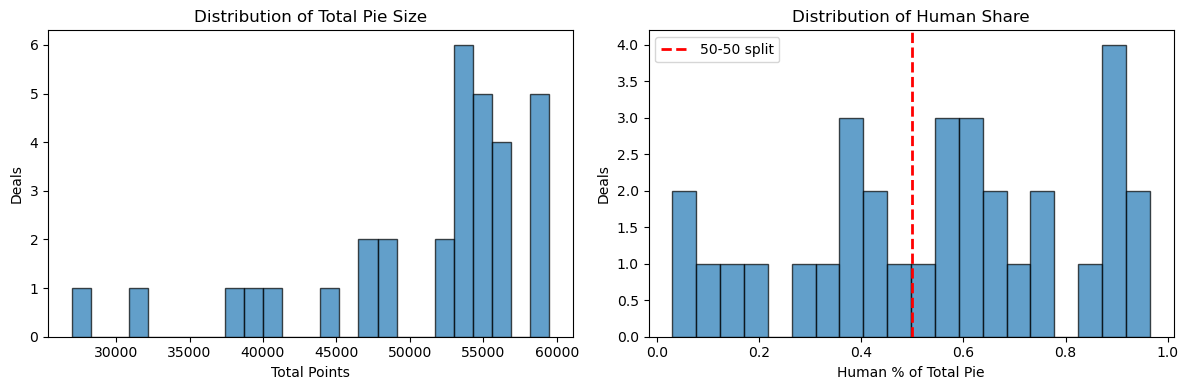

,count,mean,std,min,25%,50%,75%,max
total_pie,32.0,51184.38,8104.80,27000.00,48550.00,53500.00,56500.00,59500.00
percent_pie_human,32.0,0.55,0.28,0.03,0.37,0.57,0.77,0.96



                                  🧠 AI vs HUMAN PERFORMANCE TESTS                                   

Deals with scores: 32
Average Human Points: 28,843.8
Average AI Points: 22,340.6
Average (AI - Human): -6,503.1

Paired t-test on (AI - Human) points
  t-statistic: -1.285
  two-sided p-value: 0.2083
  one-sided p-value (AI > Human): 0.8959

                                👥 STUDENT DEMOGRAPHICS & PERFORMANCE                                


--------------------------------------------------------------------------------
📚 Academic Major Distribution
--------------------------------------------------------------------------------


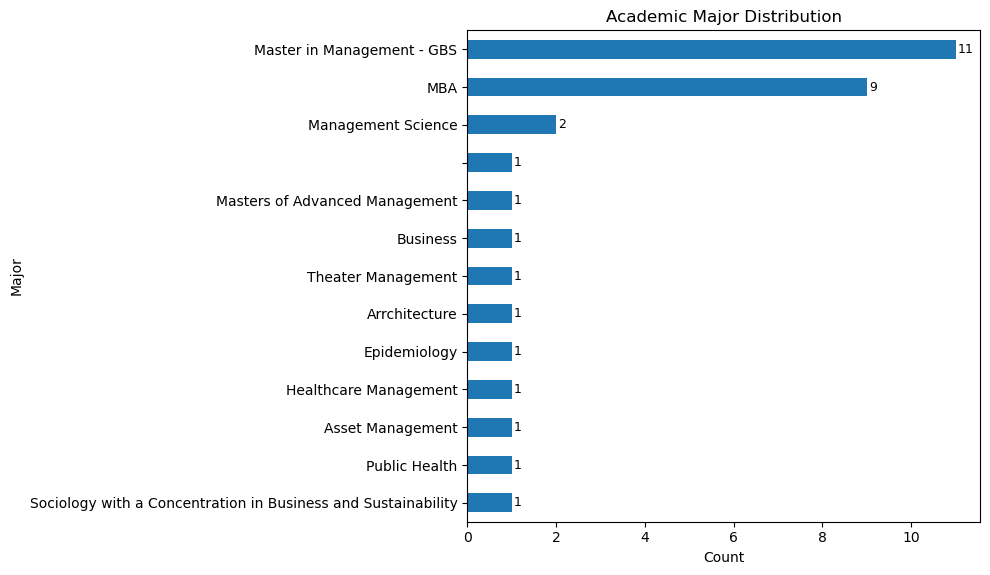


--------------------------------------------------------------------------------
⚧ Gender Distribution
--------------------------------------------------------------------------------


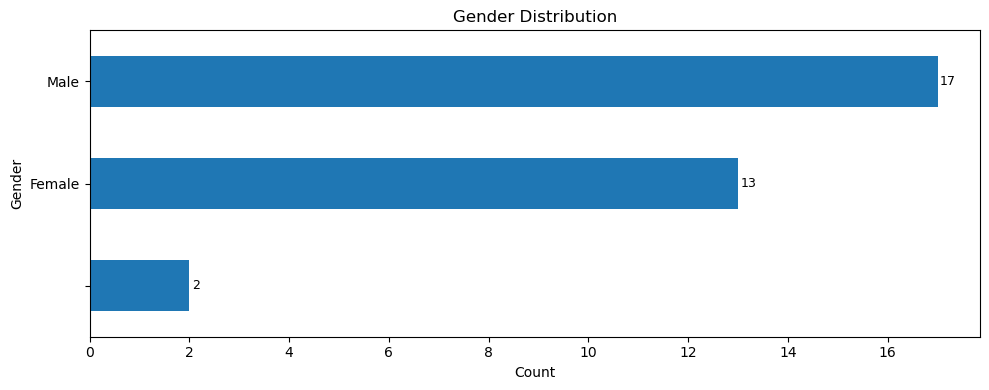


--------------------------------------------------------------------------------
💼 Negotiation Experience Distribution
--------------------------------------------------------------------------------


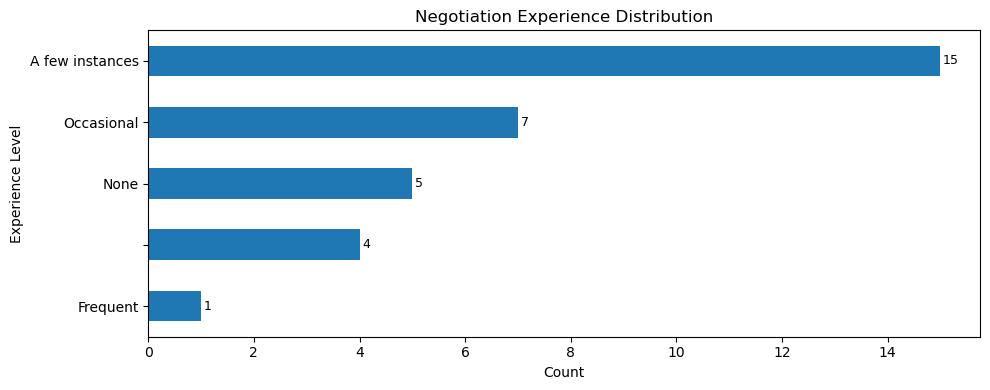


--------------------------------------------------------------------------------
📊 Performance by Demographics
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Performance by major
--------------------------------------------------------------------------------


,n_deals,avg_total_pie,avg_human_share
major,,,
,1,59500.00,0.92
Arrchitecture,1,59500.00,0.33
Epidemiology,1,56500.00,0.70
Masters of Advanced Management,1,55000.00,0.41
Sociology with a Concentration in Business and Sustainability,1,55000.00,0.77
MBA,9,53666.67,0.74
Asset Management,1,53500.00,0.56
Business,1,53500.00,0.46
Master in Management - GBS,11,51681.82,0.48



--------------------------------------------------------------------------------
Performance by gender
--------------------------------------------------------------------------------


,n_deals,avg_total_pie,avg_human_share
gender,,,
,2,59500.00,0.75
Male,17,53441.18,0.54
Female,13,46953.85,0.52



--------------------------------------------------------------------------------
Performance by negotiation_experience
--------------------------------------------------------------------------------


,n_deals,avg_total_pie,avg_human_share
negotiation_experience,,,
,4,56875.00,0.73
Frequent,1,53500.00,0.92
A few instances,15,51866.67,0.62
Occasional,7,49985.71,0.41
None,5,45800.00,0.31



                                       🎭 TREATMENT VARIATIONS                                       


--------------------------------------------------------------------------------
Role Breakdown
--------------------------------------------------------------------------------


,n_deals,avg_total_pie,avg_human_share
Role,,,
Candidate,14,49635.71,0.49
Recruiter,18,52388.89,0.60



--------------------------------------------------------------------------------
First Mover Breakdown
--------------------------------------------------------------------------------


,n_deals,avg_total_pie,avg_human_share
student_goes_first,,,
AI First,18,52805.56,0.54
Student First,14,49100.00,0.56


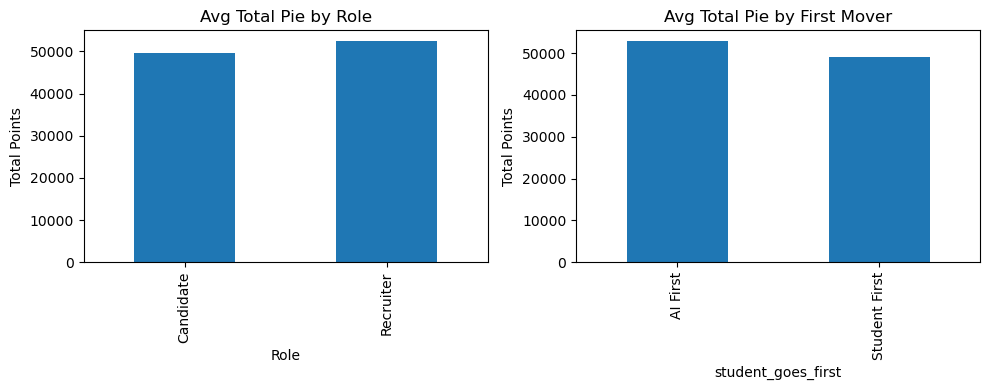

In [11]:
# ==================== MAIN EXECUTION ====================
# configure_display()
conn = sqlite3.connect(DB_PATH)
print(f"✅ Connected to: {DB_PATH}")

raw_sessions = load_sessions(conn)
print(f"Loaded {len(raw_sessions)} total sessions after cutoff")

main_street_sessions = apply_filters(raw_sessions, scenario_name="Main_Street")
main_street_sessions.to_csv(OUTPUT_MAIN_STREET_CSV, index=False)
print(f"✅ Saved {len(main_street_sessions)} Main Street sessions to {OUTPUT_MAIN_STREET_CSV}")

top_talent_sessions = apply_filters(
    raw_sessions,
    scenario_name=SCENARIO_FILTER,
    excluded_majors=EXCLUDED_MAJORS,
)

top_talent_sessions.to_csv(OUTPUT_TOP_TALENT_CSV, index=False)
print(f"✅ Saved {len(top_talent_sessions)} Top Talent sessions to {OUTPUT_TOP_TALENT_CSV}")

conn.close()
print("✅ Database connection closed")


# ==================== TOP TALENT ANALYSIS ====================
df_all = add_derived_columns(top_talent_sessions)
df_all["deal_reached"] = df_all["deal_reached"].fillna(False).astype(bool)
df_all["deal_failed"] = df_all["deal_failed"].fillna(False).astype(bool)
df_all = df_all[df_all['rounds']==6] # get rid of the failed runs

# clean up the major naming issues.
import re

MAJOR_CANONICAL_MAP = {
    "Master in Management - GBS": [
        "global business and society",
        "master in management gbs",
        "management - gbs",
        "gbs",
        "som-gbs",
        "som gbs",
    ],
    "MBA": [
        "master of business administration",
        "mba",
    ],
}
def _normalize_major(s):
    if s is None:
        return None
    s = s.lower()
    s = re.sub(r"[^a-z0-9\s]", " ", s)  # remove punctuation
    s = re.sub(r"\s+", " ", s)          # normalize whitespace
    return s.strip()

def clean_major(raw_major):
    """
    Maps messy self-reported majors into canonical program labels.
    Falls back to original string if no mapping applies.
    """
    if raw_major is None or not isinstance(raw_major, str):
        return raw_major

    norm = _normalize_major(raw_major)

    for canonical, variants in MAJOR_CANONICAL_MAP.items():
        for v in variants:
            if norm == _normalize_major(v):
                return canonical

    return raw_major.strip()
df_all['major'] = df_all['major'].apply(clean_major)

# import json
# from pprint import pprint


# # pprint(json.loads(df_all["ai_deal_json"].iloc[0]))
# df_all.loc[0]
# pprint(json.loads(df_all["student_deal_json"].loc[82]))
# print("".join(json.loads(df_all["transcript"].loc[0])))

df_all = add_scoring_columns(df_all)

df_deals = df_all[df_all["deal_reached"]].copy()

df_deals = df_deals[df_deals["total_pie"].notna()].copy()

show_overview(df_all)

show_overview_table(df_all)

analyze_pie_distributions(df_deals)

analyze_ai_vs_human(df_deals)

analyze_demographics(df_deals)

analyze_treatments(df_deals)